In [4]:
import numpy as np
import pandas as pd
import scipy
from datetime import datetime
import datetime as dt
import time
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
from plotnine import *
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

In [5]:
# Modeling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

# Similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from __future__ import print_function
from scipy.spatial.distance import cdist

# Predicting Health_Cat

This script was used to classify Health_Cat based on lsa and regional data of tweets.

## Shape the data


In [6]:
# Read the data
Test_data=pd.read_csv('Test_lsa.csv')
Test_data.shape

(37616, 307)

In [7]:
Train_data=pd.read_csv('Train_lsa_df.csv')

In [8]:
Train_data=Train_data.drop(['Unnamed: 0','Cat','Query','tweetnew2'], axis=1)
Train_data.shape

(112848, 303)

In [9]:
Train_data.head()

,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,lsa_7,lsa_8,lsa_9,lsa_10,...,lsa_294,lsa_295,lsa_296,lsa_297,lsa_298,lsa_299,lsa_300,General,Year,State
0,0.182028,0.057188,-0.018016,-0.103034,0.058709,0.029910,-0.031632,-0.091031,0.006885,-0.005903,...,0.012112,-0.000508,0.051556,0.043903,-0.016606,0.039969,-0.025871,Healthy,2015.0,pa
1,0.053156,-0.010398,-0.010187,-0.007617,-0.020911,-0.014091,-0.014784,-0.010676,0.005452,0.008119,...,-0.017390,-0.025762,0.009563,0.028161,-0.029558,-0.108558,0.028998,Healthy,2014.0,or
2,0.061546,0.021010,-0.043743,-0.004019,-0.049572,-0.014899,-0.042438,-0.002778,0.058509,0.006913,...,0.021568,0.011525,0.002123,0.033166,0.051346,0.028405,0.009108,Healthy,2014.0,mn
3,0.098676,-0.031747,-0.031175,0.002269,-0.040481,-0.018853,-0.036722,0.014207,-0.001484,0.019338,...,0.024910,-0.015053,0.001072,0.032741,-0.022067,0.015545,-0.001858,Healthy,2013.0,al
4,0.240544,0.053414,-0.141874,-0.310238,-0.093783,0.315065,-0.049980,0.313461,0.002595,0.047652,...,-0.029618,0.014742,-0.020837,0.014251,-0.013382,0.002348,0.006075,Unhealthy,2017.0,ca


In [10]:
# Let's add the health data to the tfidf data
States_dict={'Alabama' : 'AL','Alaska' : 'AK','Arizona' : 'AZ','Arkansas' : 'AR','California': 'CA','Colorado' : 'CO',
             'Connecticut' : 'CT','Delaware' : 'DE','District of columbia':'DC','Florida' : 'FL','Georgia' : 'GA','Hawaii' : 'HI','Idaho' : 'ID',
             'Illinois' : 'IL','Indiana' : 'IN','Iowa' : 'IA', 'Kansas' : 'KS','Kentucky' : 'KY','Louisiana' : 'LA','Maine':'ME',
             'Maryland' : 'MD','Massachusetts': 'MA' ,'Michigan' : 'MI','Minnesota' : 'MN', 'Mississippi' : 'MS','Missouri' : 'MO',
             'Montana' : 'MT','Nebraska' : 'NE','Nevada' : 'NV','New hampshire' : 'NH','New jersey' : 'NJ','New mexico' : 'NM',
             'New york' : 'NY', 'North carolina' : 'NC','North dakota' : 'ND', 'Ohio' : 'OH', 'Oklahoma' : 'OK','Oregon' : 'OR',
             'Pennsylvania' : 'PA', 'Rhode island' : 'RI','South carolina' : 'SC','South dakota' : 'SD','Tennessee' : 'TN',
             'Texas' : 'TX', 'Utah' : 'UT', 'Vermont' : 'VT', 'Virginia' : 'VA','Washington' : 'WA', 'West virginia' : 'WV',
             'Wisconsin' :'WI', 'Wyoming':'WY'}
print(len(States_dict))

H_data=pd.read_csv("HealthData.csv")

# Add Two letter state code to health data
H_data['State1']=H_data['State'].str.capitalize()
H_data['StateCode']=[States_dict[x] for x in H_data['State1']]

H_data['StateCode']=H_data['StateCode'].str.lower()
H_d=H_data.drop('State1',axis=1)

# Adding the population data
# Preparing the population data
Pop_data=pd.read_csv("USA_Pop1.csv")
# lowering the State name in the popdata
Pop_data['StateCode']=Pop_data['State'].str.lower()
Pop_data=Pop_data.drop('State',axis=1)
Pop_data=Pop_data.drop('part of the total U.S. pop', axis=1)
Pop_data.head()

# add the population data
H_data= pd.merge(H_data,Pop_data,on=['StateCode'])
H_data.head()

51


,Year,State,aa_Diabetes_DeathRate,aa_HeartDisease_DeathRate,Diabetes_diagnosed,ERvisits,HospStays,InpatDays,Adult Overweight/Obesity Rate,Adults Reporting Fair or Poor Health Status,State1,StateCode,Region,Division
0,2013,Alabama,24.3,228.4,0.138,472,133,697,0.682,0.228,Alabama,al,South,EastSouthCentral
1,2014,Alabama,22.8,224.0,0.129,484,130,688,0.670,0.229,Alabama,al,South,EastSouthCentral
2,2015,Alabama,21.7,229.7,0.135,508,127,704,0.687,0.222,Alabama,al,South,EastSouthCentral
3,2016,Alabama,20.1,222.5,0.146,453,130,731,0.695,0.226,Alabama,al,South,EastSouthCentral
4,2013,Alaska,20.1,135.0,0.071,350,78,512,0.661,0.150,Alaska,ak,West,Pacific


In [11]:
new=H_data.drop(['Year','State','State1','StateCode','Region','Division'], axis=1)
new.head()

,aa_Diabetes_DeathRate,aa_HeartDisease_DeathRate,Diabetes_diagnosed,ERvisits,HospStays,InpatDays,Adult Overweight/Obesity Rate,Adults Reporting Fair or Poor Health Status
0,24.3,228.4,0.138,472,133,697,0.682,0.228
1,22.8,224.0,0.129,484,130,688,0.670,0.229
2,21.7,229.7,0.135,508,127,704,0.687,0.222
3,20.1,222.5,0.146,453,130,731,0.695,0.226
4,20.1,135.0,0.071,350,78,512,0.661,0.150


In [12]:
# Let's combine the health indicators into one major health indicator
from sklearn.preprocessing import StandardScaler
normalizedHIs=StandardScaler().fit_transform(H_data.drop(['Year','State','State1','StateCode','Region','Division'], axis=1))# calculating z-scores

# normalize Combi_Health so that 1 is good health and 0 is bad health
CombiHealthIndi=np.sum(normalizedHIs, axis=1)
MAX=max(CombiHealthIndi)

# The higher the Combi Indicator the unhealthier the State
H_data['Combi_Indi']=CombiHealthIndi/MAX
H_d= H_data[['Combi_Indi','Year','StateCode','Region','Division']]
H_d.head()



C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



,Combi_Indi,Year,StateCode,Region,Division
0,0.600182,2013,al,South,EastSouthCentral
1,0.513950,2014,al,South,EastSouthCentral
2,0.562580,2015,al,South,EastSouthCentral
3,0.565647,2016,al,South,EastSouthCentral
4,-0.404361,2013,ak,West,Pacific


In [13]:
# convert State to lower case
H_d['StateCode']=H_d['StateCode'].str.lower()
H_d.head()

# Add the tweet counts to the health data
data=pd.merge(H_d,Train_data,left_on=['StateCode','Year'],right_on=['State','Year'])
data= data.drop(['StateCode'],axis=1)
#Convert General category into binary
data['General']=np.where(data['General']=='Unhealthy',1,0)
data.head()


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Combi_Indi,Year,Region,Division,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,...,lsa_293,lsa_294,lsa_295,lsa_296,lsa_297,lsa_298,lsa_299,lsa_300,General,State
0,0.600182,2013,South,EastSouthCentral,0.098676,-0.031747,-0.031175,0.002269,-0.040481,-0.018853,...,-0.065704,0.024910,-0.015053,0.001072,0.032741,-0.022067,0.015545,-0.001858,0,al
1,0.600182,2013,South,EastSouthCentral,0.028051,0.016936,-0.016182,-0.001850,-0.012465,-0.003788,...,0.005690,-0.004128,-0.017755,-0.002859,0.008861,0.012201,0.005110,-0.002190,1,al
2,0.600182,2013,South,EastSouthCentral,0.210179,0.027338,-0.029103,-0.112215,0.020549,0.009320,...,-0.001001,-0.065830,0.008846,0.025733,0.036579,-0.075995,-0.140016,0.008693,0,al
3,0.600182,2013,South,EastSouthCentral,0.153372,-0.090189,-0.018333,0.028724,-0.065652,-0.089376,...,0.014269,-0.004934,-0.021049,0.000702,0.002189,-0.007498,0.002245,0.006781,0,al
4,0.600182,2013,South,EastSouthCentral,0.091618,0.003121,-0.033694,-0.047823,-0.022902,-0.010381,...,0.024830,-0.002222,-0.031304,0.013944,0.023842,0.047044,0.026784,0.044472,0,al


## Feature engineering

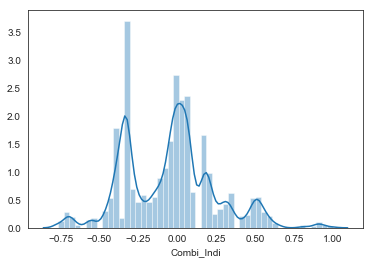

In [14]:
# Converting the Combi-Indicator into a categorical variable
# Just as a reminder the lower the value the healthier the State
sns.distplot(data['Combi_Indi'])
plt.show()

In [15]:
# Converting the data into 4 different portions
# A = very good health values (-1 --0.5)
# B = good health value (-0.5 - 0)
# C = bad health value (0 - 0.5)
# D = very bad health value (0.5 - 1)
data['Health_Cat']=0
Health_Cat=[]

for i, x in enumerate(data['Combi_Indi']):
    if i%10000==0:
        print(i)
    if data['Combi_Indi'][i] < -0.5:
        Health_Cat.append('A')
    elif (data['Combi_Indi'][i] > -0.5 
          and data['Combi_Indi'][i] <0) :
        Health_Cat.append('B')
    elif (data['Combi_Indi'][i] > 0 
          and data['Combi_Indi'][i] <0.5) :
        Health_Cat.append('C')
    elif data['Combi_Indi'][i] > 0.5:
        Health_Cat.append('D')
data['Health_Cat']=Health_Cat
data['Health_Cat'].value_counts()

0
10000
20000
30000
40000
50000
60000
70000
80000


B    47553
C    31759
D     4714
A     2955
Name: Health_Cat, dtype: int64

In [16]:
# Conerting the categorical data into binaries
Catdata= data[['Region','Division','State']]
DummyData=pd.get_dummies(Catdata)
numData=pd.concat([data.drop(['Region','Division','State','Year'],axis=1),DummyData],axis=1)
numData.head()

,Combi_Indi,lsa_1,lsa_2,lsa_3,lsa_4,lsa_5,lsa_6,lsa_7,lsa_8,lsa_9,...,State_pa,State_ri,State_sc,State_sd,State_tn,State_tx,State_ut,State_vt,State_wa,State_wv
0,0.600182,0.098676,-0.031747,-0.031175,0.002269,-0.040481,-0.018853,-0.036722,0.014207,-0.001484,...,0,0,0,0,0,0,0,0,0,0
1,0.600182,0.028051,0.016936,-0.016182,-0.001850,-0.012465,-0.003788,-0.008152,-0.008289,0.009551,...,0,0,0,0,0,0,0,0,0,0
2,0.600182,0.210179,0.027338,-0.029103,-0.112215,0.020549,0.009320,-0.042097,-0.084879,0.021942,...,0,0,0,0,0,0,0,0,0,0
3,0.600182,0.153372,-0.090189,-0.018333,0.028724,-0.065652,-0.089376,-0.115554,0.022423,-0.015860,...,0,0,0,0,0,0,0,0,0,0
4,0.600182,0.091618,0.003121,-0.033694,-0.047823,-0.022902,-0.010381,-0.002685,-0.053919,-0.010912,...,0,0,0,0,0,0,0,0,0,0


## Balance dataset

In [17]:
# Now let's oversample the different categories using SMOTE
# I don't get why this is not working
# https://github.com/scikit-learn-contrib/imbalanced-learn/issues/528
#from imblearn.over_sampling import SMOTE
#from collections import Counter

#sm = SMOTE(random_state=42)
#X= data.drop(['Health_Cat','State','Combi_Indi'],axis=1)
#y= data['Health_Cat']
#X_res, y_res = sm.fit_resample(X, y)
#y_res.value_counts()

In [19]:
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-10-10.0.17134-SP0
Python 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
NumPy 1.16.1
SciPy 1.1.0
Scikit-Learn 0.20.3


In [18]:
# Let's downsample instead
# Number of observations in each class
print(data['Health_Cat'].value_counts())
# For every observation of class 0, randomly sample from class 1 without replacement
#i_class1_downsampled = np.random.choice(i_class1, size=n_class0, replace=False)

B    47553
C    31759
D     4714
A     2955
Name: Health_Cat, dtype: int64


In [60]:
# Indicies of each class' observations
i_classA = np.where(y == 'A')[0]


# Number of observations in the smallest class
n_classA = len(i_classA)

A_data= numData[numData['Health_Cat']=='A']
B_data= numData[numData['Health_Cat']=='B']
C_data= numData[numData['Health_Cat']=='C']
D_data= numData[numData['Health_Cat']=='D']

B_data_us=B_data.sample(n_classA)
print(B_data_us.shape)
C_data_us=C_data.sample(n_classA)
print(C_data_us.shape)
D_data_us=D_data.sample(n_classA)
print(D_data_us.shape)

data_us = pd.concat([A_data, B_data_us,C_data_us,D_data_us], axis=0)
print(data_us.shape)

(2955, 363)
(2955, 363)
(2955, 363)
(11820, 363)


In [62]:
numData.columns

Index(['Combi_Indi', 'lsa_1', 'lsa_2', 'lsa_3', 'lsa_4', 'lsa_5', 'lsa_6',
       'lsa_7', 'lsa_8', 'lsa_9',
       ...
       'State_pa', 'State_ri', 'State_sc', 'State_sd', 'State_tn', 'State_tx',
       'State_ut', 'State_vt', 'State_wa', 'State_wv'],
      dtype='object', length=363)

In [65]:
X= data_us.drop(['Health_Cat','Combi_Indi'],axis=1).values
print(X.shape)
y= data_us['Health_Cat']
print(y.shape)
y.value_counts()

(11820, 361)
(11820,)


C    2955
A    2955
B    2955
D    2955
Name: Health_Cat, dtype: int64

## Classification

### Functions

In [66]:
# Modeling
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

In [67]:
from sklearn.naive_bayes import GaussianNB
def runNB(input_df, target, no_folds):
    start_time=time.time()
    nb = GaussianNB()
    #nb.fit(input_df, target)
    print('Naive Bayes')
    
    cvs = cross_val_score(nb, input_df, target, cv=no_folds)    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [68]:
def runRFC_class(input_df, target, no_folds):
    start_time=time.time()
    param_grid= {'n_estimators': [50,100,200,500]}
    print('Random Forest')
    rand_forest_class = ensemble.RandomForestClassifier()
    CV_model = GridSearchCV(estimator=rand_forest_class, param_grid=param_grid, cv= 5)
    
    CV_model.fit(input_df, target)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds) 
    print("Best parameters:", CV_model.best_params_) 
    #print('Feature Importance:{}',rand_forest_class.feature_importances_)
       
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [69]:
def runKNN_class(input_df, target,no_folds):
    start_time=time.time()
    param_grid= {'n_neighbors': [ 3,5,10]}
    print('KNN')
    knn_w = neighbors.KNeighborsClassifier(weights='distance')
    CV_model = GridSearchCV(estimator=knn_w, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_)
    # cross validation
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy KNN with weights: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [70]:
def runLogit(input_df,target,no_folds):
    start_time=time.time()

    logreg = linear_model.LogisticRegression()
    
    #logreg.fit(input_df, target)
    print('Logistic regression')
    #print('Coefficients Log Regression:',logreg.coef_)
      
    cvs = cross_val_score(logreg, input_df, target, cv=no_folds)
   
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()

    return(cvs)

In [71]:
def runLasso(input_df,target,no_folds):
    start_time=time.time()
    print('Lasso')
    param_grid = {'C': [ 0.1,0.5, 1,2,5, 10,100]}
    lasso = linear_model.LogisticRegression(penalty='l2')
    CV_model = GridSearchCV(estimator=lasso, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [72]:
def runRidge(input_df,target,no_folds):
    start_time=time.time()
    print('Ridge')
    param_grid = {'C': [ 0.1,0.5, 1,5, 10,50,100]}
    ridge = linear_model.LogisticRegression(penalty='l1')
    CV_model = GridSearchCV(estimator=ridge, param_grid=param_grid, cv= 5)
    CV_model.fit(input_df, target)
    
    #print('Coefficients Log Regression:',logreg.coef_)
    cvs = cross_val_score(CV_model, input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_)

In [73]:
def runSVM(input_df,target,no_folds):
    print('Support Vector Machine')
    start_time=time.time()
    param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 20, 1e2, 1e3,1e4 ]}
    svm = SVC(kernel = 'linear') 
    CV_model = GridSearchCV(estimator=svm, param_grid=param_grid, cv= 2)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} seconds.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    print()
    return(cvs)

In [91]:
def runMLP(input_df,target,no_folds): 
    param_grid = {'hidden_layer_sizes':[[361,4],[361,484,4],[361,100,100,100,100,4]],
                 'activation':['identity','relu','tanh','logistic'],
                 'learning_rate':['adaptive'],
                 'batch_size':['auto'],
                 'max_iter':[500]}
    start_time= time.time()
    print('Multi layer perceptron')
    mlp = MLPClassifier() 
    CV_model = GridSearchCV(estimator=mlp, param_grid=param_grid, cv= 2)
    CV_model.fit(input_df, target)
    cvs=cross_val_score(CV_model,input_df, target, cv=no_folds)
    print("Best parameters:", CV_model.best_params_) 
    print('Time taken: {} minutes.'.format('%.3f' % (time.time() - start_time)))
    print('Average accuracy RFC: {}'.format('%.3f' % cvs.mean()))
    print('Standard deviation of accuracy: {}'.format('%.3f' % np.std(cvs, ddof=1)))
    runtime=time.time() - start_time
    print()
    return(cvs)

### First trial

In [75]:
cvs_NB= runNB(X, y, 3)

Naive Bayes
Time taken: 0.992 seconds.
Average accuracy RFC: 0.916
Standard deviation of accuracy: 0.004



In [76]:
cvs_KNN= runKNN_class(X,y,3)

KNN
Best parameters: {'n_neighbors': 10}
Time taken: 2768.476 seconds.
Average accuracy KNN with weights: 0.948
Standard deviation of accuracy: 0.000



In [77]:
cvs_RFC= runRFC_class(X,y,3)

Random Forest
Best parameters: {'n_estimators': 50}
Time taken: 2545.084 seconds.
Average accuracy RFC: 0.895
Standard deviation of accuracy: 0.097



In [78]:
cvs_logit= runLogit(X,y,3)

Logistic regression


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

Time taken: 6.189 seconds.
Average accuracy: 0.896
Standard deviation of accuracy: 0.097



In [79]:
cvs_ridge= runRidge(X,y,3)

Ridge


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

Best parameters: {'C': 0.5}


In [80]:
cvs_lasso= runLasso(X,y,3)

Lasso


C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

C:\Users\Ruecker-PC\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence

Best parameters: {'C': 0.5}
Time taken: 307.148 seconds.
Average accuracy: 0.897
Standard deviation of accuracy: 0.096



In [81]:
cvs_SVM= runSVM(X,y,3)

Support Vector Machine
Best parameters: {'C': 0.1}
Time taken: 1190.746 seconds.
Average accuracy: 0.793
Standard deviation of accuracy: 0.014



In [92]:
cvs_MLP= runMLP(X,y,3)

Multi layer perceptron
Best parameters: {'activation': 'tanh', 'batch_size': 'auto', 'hidden_layer_sizes': [361, 4], 'learning_rate': 'adaptive', 'max_iter': 500}
Time taken: 7179.013 minutes.
Average accuracy RFC: 0.894
Standard deviation of accuracy: 0.057



Text(0.5, 0, 'Models tried')

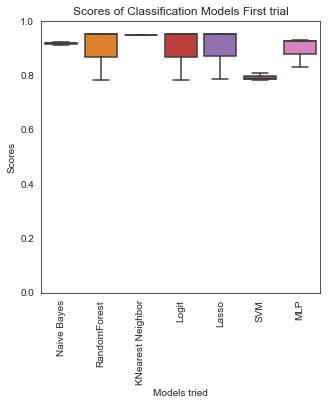

In [96]:
# Plot the results
Scores = {'Naive Bayes': cvs_NB,
          'RandomForest': cvs_RFC,
          'KNearest Neighbor':cvs_KNN, 
          'Logit':cvs_logit,
          'Lasso':cvs_lasso,
          #'Ridge':cvs_ridge,
          'SVM':cvs_SVM,
         'MLP':cvs_MLP}
Scoreresults = pd.DataFrame(data=Scores, index=(range(3)))

# Make a boxplot for comparison
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
im = sns.boxplot(data=Scoreresults[Scoreresults.columns], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim(0,1)
im.set_title('Scores of Classification Models First trial')
im.set_ylabel('Scores')
im.set_xlabel('Models tried')

## Sensitivity and Specificity

In [105]:
model = neighbors.KNeighborsClassifier(weights='distance',n_neighbors=10)
y_pred = cross_val_predict(model,X,y,cv=3)

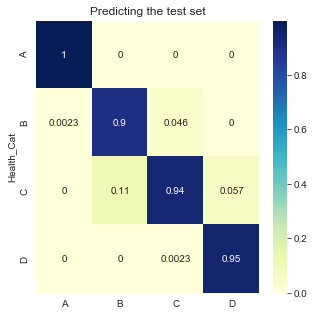

In [114]:
from pandas import crosstab
confma=crosstab(y,y_pred)
confma['RowSum']= confma.sum()
confma_p=pd.DataFrame()
confma_p['A']=confma['A']/confma.RowSum
confma_p['B']=confma['B']/confma.RowSum
confma_p['C']=confma['C']/confma.RowSum
confma_p['D']=confma['D']/confma.RowSum

# Plot persentage matrix
plt.figure(figsize=(5,5))
sns.heatmap(confma_p,cmap="YlGnBu", annot =True)
plt.title('Predicting the test set')
plt.show()
